c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Epoch 1 | Loss: 1517.0820 | Acc: 85.52% | Energy (spikes/sample): 996.11
Epoch 2 | Loss: 1434.4483 | Acc: 92.94% | Energy (spikes/sample): 1058.36
Epoch 3 | Loss: 1420.9621 | Acc: 94.43% | Energy (spikes/sample): 1050.27
Epoch 4 | Loss: 1412.7435 | Acc: 95.41% | Energy (spikes/sample): 1045.13
Epoch 5 | Loss: 1407.3131 | Acc: 96.01% | Energy (spikes/sample): 1039.72


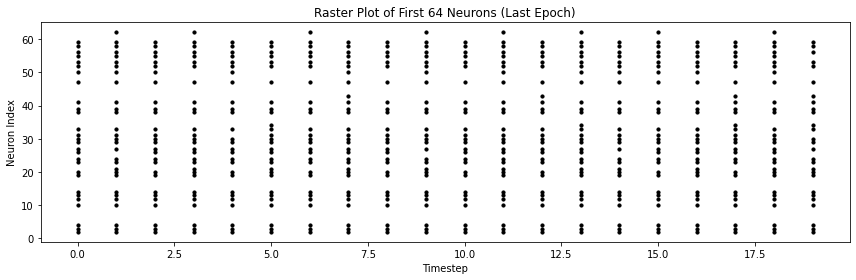

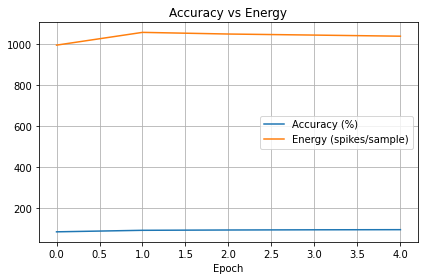

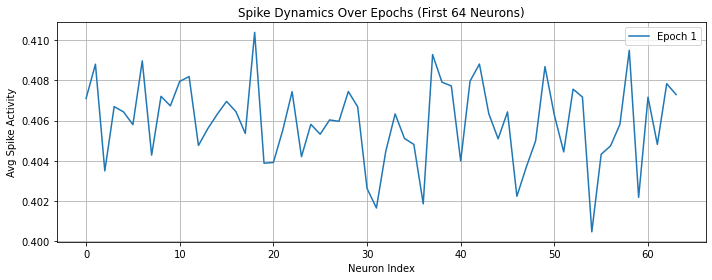

In [1]:
"""
Spiking Neural Network Training on MNIST using SpikingJelly
============================================================

This script trains a simple SNN model on the MNIST dataset using Poisson
spike encoding and LIF neurons from SpikingJelly. It also visualizes spike
activity and performance over training epochs.

Author: [Your Name]
Date: [Today's Date]
"""

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from spikingjelly.activation_based import neuron, surrogate, functional, encoding

# ==== Hyperparameters ====
batch_size = 64
epochs = 5
time_steps = 20  # Number of simulation steps
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# ==== Data Preprocessing ====
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x * 2 - 1)  # Normalize to [-1, 1]
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# ==== Poisson Spike Encoder ====
encoder = encoding.PoissonEncoder()

# ==== Spiking Neural Network Definition ====
class SNN(nn.Module):
    """
    A simple 2-layer feedforward SNN with LIF neurons and surrogate gradients.
    """
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.lif1 = neuron.LIFNode(tau=2.0, surrogate_function=surrogate.Sigmoid())
        self.fc2 = nn.Linear(128, 10)
        self.lif2 = neuron.LIFNode(tau=2.0, surrogate_function=surrogate.Sigmoid())

    def forward(self, x, record_spikes=False):
        """
        Forward pass with temporal dynamics over time_steps.
        Optionally records spikes from first hidden layer.
        """
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        spike_record = []
        spike_count = 0
        out_acc = 0

        for t in range(time_steps):
            spike_in = encoder(x).float()  # Encode to spikes
            out = self.fc1(spike_in)
            out = self.lif1(out)
            spike1 = out > 0
            out = self.fc2(out)
            out = self.lif2(out)

            if record_spikes:
                spike_record.append(spike1.detach().cpu().numpy())

            spike_count += spike1.sum().item()
            out_acc += out  # Accumulate outputs over time

        return out_acc / time_steps, spike_record if record_spikes else None, spike_count

# ==== Initialize Model, Optimizer, Loss ====
model = SNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# ==== Tracking Metrics ====
epoch_acc = []
epoch_energy = []
epoch_spike_trends = []

# ==== Training Loop ====
for epoch in range(epochs):
    model.train()
    correct = 0
    total = 0
    total_loss = 0
    total_spikes = 0
    spike_heat = []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs, spike_record, spike_count = model(images, record_spikes=(epoch == epochs - 1))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Reset neuron states at the end of each forward pass
        functional.reset_net(model)

        total_loss += loss.item()
        total_spikes += spike_count
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Collect spike activity (for last epoch only)
        if spike_record:
            avg_spikes = np.mean(np.array(spike_record), axis=(0, 2))  # Mean spike activity per neuron
            avg_spikes = np.pad(avg_spikes, (0, 128 - len(avg_spikes)), mode='constant')  # Pad to 128
            spike_heat.append(avg_spikes)

    accuracy = 100. * correct / total
    energy = total_spikes / total  # Spikes per sample
    epoch_acc.append(accuracy)
    epoch_energy.append(energy)

    if spike_heat:
        epoch_spike_trends.append(np.mean(spike_heat, axis=0))

    print(f"Epoch {epoch + 1} | Loss: {total_loss:.4f} | "
          f"Acc: {accuracy:.2f}% | Energy (spikes/sample): {energy:.2f}")

# ==== Raster Plot for Last Epoch ====
def plot_raster(spike_record, n_neurons=64):
    """
    Plots a raster plot of spike times for the first sample and first `n_neurons`.
    """
    fig, ax = plt.subplots(figsize=(12, 4))
    for t, spikes in enumerate(spike_record):
        neuron_ids = np.where(spikes[0][:n_neurons] > 0)[0]
        ax.scatter([t] * len(neuron_ids), neuron_ids, s=10, c='black')
    ax.set_title("Raster Plot of First 64 Neurons (Last Epoch)")
    ax.set_xlabel("Timestep")
    ax.set_ylabel("Neuron Index")
    plt.tight_layout()
    plt.show()

# Display raster plot (last epoch only)
if spike_record:
    plot_raster(spike_record)

# ==== Accuracy vs Energy Plot ====
plt.figure()
plt.plot(epoch_acc, label='Accuracy (%)')
plt.plot(epoch_energy, label='Energy (spikes/sample)')
plt.xlabel("Epoch")
plt.title("Accuracy vs Energy")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# ==== Spike Dynamics Over Epochs ====
plt.figure(figsize=(10, 4))
for i, spikes in enumerate(epoch_spike_trends):
    plt.plot(spikes[:64], label=f'Epoch {i + 1}')
plt.xlabel("Neuron Index")
plt.ylabel("Avg Spike Activity")
plt.title("Spike Dynamics Over Epochs (First 64 Neurons)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


This image is a raster plot, a common visualization used in spiking neural networks (SNNs) to represent the spike activity of neurons over time.

Interpretation:
X-axis (Timestep): Represents simulation time (from 0 to 20 in this case). Each column corresponds to a timestep during which the input was presented and spikes were processed.

Y-axis (Neuron Index): Represents neuron IDs (from 0 to 63 here). Each row corresponds to a particular neuron in the layer (usually the hidden layer).

Dots: Each dot at position (t, n) indicates that neuron n fired (spiked) at timestep t.

This is a line plot showing the average spike activity of neurons in the spiking neural network (SNN) during Epoch 1 of training.
 Interpretation:
X-axis (Neuron Index): Represents the indices of the first 64 neurons in the layer you are monitoring (likely the hidden layer after fc1 + lif1).

Y-axis (Avg Spike Activity): Shows the average number of spikes per neuron across all timesteps and batches in that epoch.

